# Class 4: Consensus motifs

---
# Before Class
In class today we will be building PWMs and using them to idenfity binding sites in a sequence.

Prior to class, please do the following:
1. Install `pdf2svg` on your machine:
    1. On linux: `$ sudo apt-get install pdf2svg`
    1. On mac: `$ brew install pdf2svg`
1. Install `seqlogo` in your b529 environment using: `$ pip install seqlogo`
1. Review slides on PWMs in detail
1. Review the structure of a gene and why we reverse complement 
1. Review or read up on Python syntax for:
      1. numpy ndarray operations (https://docs.scipy.org/doc/numpy-1.15.0/user/quickstart.html)
      1. str.maketrans() and str.translate (https://docs.python.org/3/library/stdtypes.html#str.translate)
      1. seqlogo (https://github.com/betteridiot/seqlogo)
      1. functions from previous class


---
## Learning Objectives

1. Build motifs from consensus sequences
* Plot motifs as a sequence logo
* Use motifs to score sequence and identify matches

---
## Background

As seen in the lecture, one type of transcriptional regulation is through control by transcription factors. These bind specific sequences known as transcription factor binding sites (TFBS). Unlike our previous class, these sites are more degenerate than a specific sequence and so basic pattern matching through the use of regular expressions is not sufficient to describe these sequences.

Our goal today will be to implement the use of PWMs to identify binding sites for a specific TFBS.

We will need to install the seqlogo package to complete today's assignment:

```$ pip install seqlogo```

We also need the pdf to svg converter for the graphics:
On linux: ```$ sudo apt-get install pdf2svg```
On mac: ```$ brew install pdf2svg```

---
## Imports

In [1]:
import sys
import os
import numpy as np

#import function from previous class for building sequence motif & idenfitying seqs matching to motif
sys.path.insert(0, '../shared/')
from data_readers import get_fasta
from seq_ops import reverse_complement

---
## Build sequence motif

Given a provided list of sequence k-mers we are going to build a consensus motif. Recall from lecture slides...

$PFM = \begin{bmatrix}
    x_{A1} & x_{A2} & x_{A3} & \dots & x_{An} \\
    x_{C1} & x_{C2} & x_{C3} & \dots & x_{Cn} \\
    x_{G1} & x_{G2} & x_{G3} & \dots & x_{Gn} \\
    x_{T1} & x_{T2} & x_{T3} & \dots & x_{Tn}
\end{bmatrix}$

$PWM = log_{2} \Big(\frac{x_{ij} + p_{i}}{\sum_{i=A,C,G,T}x_{ij}+\sum_{i=A,C,G,T}p_{i}}\Big) - log_{2}(b_{i})$

Where, $x_{ij}$ is the number of times nucleotide $i$ is observed at position $j$, $p_{i}$ is the pseudocount or Laplace estimator, and $b_{i}$ is the expected probability ($\textit{a priori}$) of observing nucleotide $i$ overall. In this assignment, we will use a pseudocount of $0.25$ and a uniform background probability of $0.25$.

Using your code developed in the previous class and the FASTA file in data/class4.fa write a program to read in the raw sequence reads, convert these into a Position Frequency Matrix, and then convert this into a PWM. 

In [4]:
np.zeros( (4, 5) )

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [84]:
def build_pfm(sequences, length):
    """Function to build a PFM using entries from a fasta file

    Args:
        sequences (list): list of sequence strings
        length (int): size of pfm we are building

    Returns:
        pfm (numpy array): dimensions are 4xlength
        
    Pseudocode:
        Initialize 4xlength numpy array as pfm (standard row order is alphabetical: A, C, G, T)
        for each sequence:
            for j in 1 to sequence length:
                increment pfm[base, j]
    """
    
    from collections import defaultdict
    
    toreturn = [ defaultdict( lambda: 0 ) for i in range( length ) ]
    for seq in sequences:
        seq = seq.upper()
        for i, c in enumerate( seq ):
            toreturn[i][c] += 1
            
    toreturn2 = np.zeros( ( 4, len( sequences[0] ) ), dtype=int )
    
    for i, b in enumerate( 'ACGT' ):
        for j in range( length ):
            toreturn2[i][j] = toreturn[j][b] 
        
    return toreturn2
    
                        
    


In [100]:
def build_pwm(pfm, p=0.25, bp=0.25 ):
    """Function to build a PWM from a PFM

    Args:
        pfm (numpy array): dimensions are 4xlength

    Returns:
        pwm (numpy array): dimensions are 4xlength
        
    Pseudocode:
        Initialize 4xlength numpy array as pfm (standard row order is alphabetical: A, C, G, T)
        Calculate column sums as sums
        for i in A,C,G,T:
            for j in 1 to pfm length:
                pwm[i, j] = log2( (pfm[i,j] + p) / (sums[j] + p*4) ) - log2(background probability)
    """

    toreturn = np.zeros( pfm.shape )
    
    sums = np.sum( pfm, axis=0 )
    for i, b in enumerate( 'ACGT' ):
        for j in range( pfm.shape[1] ):
            toreturn[ i, j ] = (pfm[i,j] + p) / (sums[j] + p*4)
            toreturn[ i, j ] = np.log2( toreturn[ i, j ] ) - np.log2( bp )
    
    return toreturn



In [97]:
b=0.25
np.log2( b )

-2.0

In [101]:
# File containing the list of sequences for our PWM
file_name = 'data/class4.fa'

# Read sequences from file into list
sequences = []
for name, seq in get_fasta(file_name):
    sequences.append(seq)

# Build pfm
pfm = build_pfm(sequences, 20)
print (pfm)

# Build PWM
pwm = build_pwm(pfm)
print (pwm)

[[ 60   0  46  77   0   0 171  18  27 229   0 111   0   0   0  36  88   0
   37  72]
 [ 47  82  41   0 229 229   0 112 144   0   0   0   0   0   0 171   0 135
   96  74]
 [ 69  40 103 152   0   0  30  99  19   0 229 118 142 229 229   0 127  94
   32  70]
 [ 53 107  39   0   0   0  28   0  39   0   0   0  87   0   0  22  14   0
   64  13]]
[[ 0.06739929 -7.84549005 -0.31410859  0.42597298 -7.84549005 -7.84549005
   1.57447013 -1.65566549 -1.07730573  1.99528787 -7.84549005  0.95217147
  -7.84549005 -7.84549005 -7.84549005 -0.66558096  0.61803432 -7.84549005
  -0.62632153  0.32943563]
 [-0.28324763  0.51645372 -0.47916784 -7.84549005  1.99528787  1.99528787
  -7.84549005  0.96508158  1.32693746 -7.84549005 -7.84549005 -7.84549005
  -7.84549005 -7.84549005 -7.84549005  1.57447013 -7.84549005  1.23399473
   0.74322458  0.36882907]
 [ 0.26825212 -0.51457317  0.84450792  1.40480837 -7.84549005 -7.84549005
  -0.92662681  0.78750515 -1.57870351 -7.84549005  1.99528787  1.04020632
   1.30679479

---
## Plot motif as logo

A typical way to display PWMs is a sequence logo. This is plot displaying the information content at each base position in the motif that we just generated. An example is below:
<center><img src='./figures/demoLogo.png'/ width=600px></center>

See documentation for this package here: https://github.com/betteridiot/seqlogo

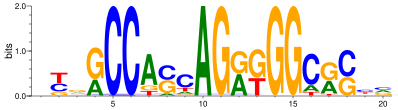

In [115]:
import seqlogo

# Use the seqlogo package to plot the PFM built above
# Hint: This can be done in 1 or 2 lines of code
# Hint 2: the seqlogo expects the transpose of our pfm matrix, this can be done on a numpy array using the member function T: pfm.T


seqlogo.seqlogo( seqlogo.CompletePm( seqlogo.Pfm( pfm.T ) ) )

---
## Identify sequence matches to motif

We are now going to scan the promoter regions (identified from last class) for matches to our motif. As we scan, consider each k-length sequence substring in both forward and reverse orientation for the entirety of each promoter.

In order to calculate the score at each position, we take the sum of the matching columns to a k-mer. This is becuase each position now represents the log likelihood of observing a base at that position:

k-mer : ACTAG

  | N | 1 | 2 | 3 | 4 | 5 |
  |:---:|:---:|:---:|:---:|:---:|:---:|
| A | **0.26** | 1.26 | -1.32 | **1.49** | -0.32 |
| C | -0.32 | **-0.32** | -1.32 | -1.32 | -1.32 |
| G | -1.32 | -1.32 | 1.49 | -1.32 | **1.0** |
| T | 0.68 | -1.32 | **-1.32** | -1.32 | -1.32 |
| $\sum$ | 0.26 | -0.32 | -1.32 | 1.49 | 1.0 |

= 1.11

In [169]:
# Write a set of functions to score a string with your PWM generated above.
# Expected input: DNA string, PWM
# Expected output: highest score and location of best PWM match in the sequence
# Note: Remember to also scan the reverse compliment of the sequence!
from collections import defaultdict

def score_kmer(seq, pwm):
    """Function to score a kmer with a pwm
        kmer length is expected to be the same as pwm length

    Args:
        seq(str): kmer to score
        pwm (numpy array): pwm for scoring

    Returns:
        score (float): PWM score for kmer
        
    Pseudocode:
        score = 0
        for j in seq length
            score = score + pwm[seq[j], j]
    """
    
    score = 0.0
    trans = { 'A':0, 'C':1, 'G':2, 'T':3 }
    
    for i, b in enumerate( seq ):
        score += pwm[ trans[ b ], i ]
        
    return score


def score_nmer(seq, pwm):
    """Function to score a nmer with a pwm
        This will scan sequence and score all 
        subsequences of length k with a pwm
        and return the maximum score

    Args:
        seq(str): nmer to score
        pwm (numpy array): pwm for scoring

    Returns:
        score (float): PWM score for nmer
        position (int): 0-based index of the best match location
         Note: for negative strand still report left-most base position
        strand (int): 0 for positive strand, 1 for negative strand
        
    Pseudocode:
        max_score = -100
        for i pwm-length kmers in seq:
            if kmer > max:
                keep score, i, strand
                max = score
            if reverse compliment kmer > max:
                keep score, i, strand
                max = score            
            
    """
    
    k = pwm.shape[1]
    max_score = -1000
    max_res = ( None, None, None )
    
    def chunks(l, n):
        for i in range( len( l ) - n + 1 ):
            yield (i, l[i:i+n])
    
    for i, s in chunks( seq, k ):
        score = score_kmer(s, pwm)
        if score > max_score:
            max_res = ( score, i, 0 )
            max_score = score
            
        score = score_kmer( reverse_complement( s ), pwm)
        if score > max_score:
            max_res = ( score, i, 1 )
            max_score = score
            
    return max_res
    


In [170]:
# Testing your functions. The following should output (7.477562910794718, 6, 0)
print (score_nmer('TAGAGAACAACCAAAAGAGGGGACAAGGGTATA', pwm))

(7.477562910794718, 6, 0)


In [ ]:
# Now apply this to the code from last class to score the promoters
# You will need to extract all of the promoter regions (as done in the previous class)
# and then score these regions using your score_nmer() function above. Please output (print)
# the sequence, score of the best hit, position of the best hit, and the strand of the
# best hit.

# Import all of our class 3 functions
from data_readers import *
from seq_ops import *

seq_file="../class_3/data/GCF_000009045.1_ASM904v1_genomic.fna.gz"
gff_file="../class_3/data/GCF_000009045.1_ASM904v1_genomic.gff.gz"



